https://github.com/JTreguer/ia-bdx-ts-project3

# Part 1

* Make a sinus function
* Simple RNN
* LSTM 
* GRU 

## Sinus function

In [2]:
import numpy as np
import numpy
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import math

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import SimpleRNN
from keras.layers.recurrent import GRU
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import xgboost as xgb
import imageio
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

%matplotlib inline

Using TensorFlow backend.
C:\Users\Utilisateur\Anaconda3\envs\computervision\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Utilisateur\Anaconda3\envs\computervision\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Utilisateur\Anaconda3\envs\computervision\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:

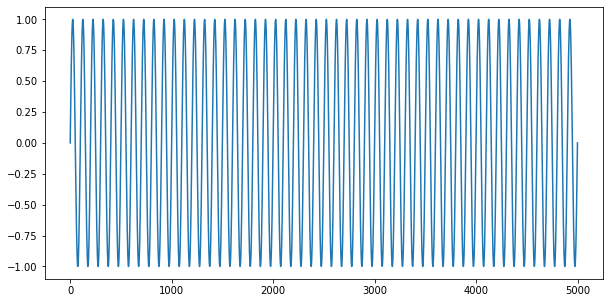

In [2]:
#sinus curve, i.e.: y=sin(x)
SAMPLES = 5000
PERIOD = 50
x = np.linspace(-PERIOD * np.pi, PERIOD * np.pi, SAMPLES) #reshape (-1,1)
series = pd.DataFrame(np.sin(x))

plt.figure(figsize = (10, 5))
plt.plot(series.values)
plt.show()

In [3]:
# Normalize data on the (-1, 1) interval.
scaler = MinMaxScaler(feature_range = (-1, 1))
scaled = scaler.fit_transform(series.values)

# Convert to data frame.
series = pd.DataFrame(scaled)

window size = 50The number of previous time steps

In [4]:
# Helper function to create a windowed data set.

def create_window(data, window_size = 1):    
    data_s = data.copy()
    for i in range(window_size):
        data = pd.concat([data, data_s.shift(-(i + 1))], 
                            axis = 1)
        
    data.dropna(axis=0, inplace=True)
    return(data)

# Show series
series_backup = series.copy()
t = create_window(series_backup, 1)
t.head()

,0,0
0,-9.821934e-16,0.062803
1,6.280307e-02,0.125358
2,1.253582e-01,0.187418
3,1.874184e-01,0.248739
4,2.487386e-01,0.309077


In [5]:
window_size = 50
series = create_window(series, window_size)
print("Shape of input data:")
print(series.shape)

Shape of input data:
(4950, 51)


In [6]:
# Split: using 67% of data for training, 33% for validation.

TRAIN_SIZE = 0.67

nrow = round(TRAIN_SIZE * series.shape[0])

train = series.iloc[:nrow, :]
test = series.iloc[nrow:, :]

# Shuffle training data.
train = shuffle(train)

train_X = train.iloc[:, :-1]
test_X = test.iloc[:, :-1]

train_Y = train.iloc[:, -1]
test_Y = test.iloc[:, -1]

print("Training set shape for X (inputs):")
print(train_X.shape)
print("Training set shape for Y (output):")
print(train_Y.shape)

Training set shape for X (inputs):
(3316, 50)
Training set shape for Y (output):
(3316,)


In [7]:
# Reshape datasets
train_X = np.reshape(train_X.values, (train_X.shape[0], train_X.shape[1], 1))
test_X = np.reshape(test_X.values, (test_X.shape[0], test_X.shape[1], 1))

print(train_X.shape)
print(test_X.shape)

(3316, 50, 1)
(1634, 50, 1)


## RNN

In [8]:
window_size = 50

# Define the model.
model = Sequential()
model.add(SimpleRNN(4, input_shape = (window_size, 1)))
model.add(Dense(1))

model.compile(loss = "mean_squared_error", optimizer = "adam")

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Fit the first model.
model.fit(train_X, train_Y, epochs = 10, batch_size = 1, validation_data = (test_X, test_Y))

Instructions for updating:
Use tf.cast instead.
Train on 3316 samples, validate on 1634 samples
Epoch 1/10
3316/3316 [==============================] - 35s 11ms/step - loss: 0.1245 - val_loss: 0.0012
Epoch 2/10
3316/3316 [==============================] - 36s 11ms/step - loss: 5.2191e-04 - val_loss: 1.9077e-04
Epoch 3/10
3316/3316 [==============================] - 36s 11ms/step - loss: 1.4519e-04 - val_loss: 5.0449e-05
Epoch 4/10
3316/3316 [==============================] - 37s 11ms/step - loss: 8.9133e-05 - val_loss: 4.7334e-05
Epoch 5/10
3316/3316 [==============================] - 38s 12ms/step - loss: 5.7497e-05 - val_loss: 7.6738e-05
Epoch 6/10
3316/3316 [==============================] - 38s 11ms/step - loss: 5.2387e-05 - val_loss: 3.4086e-05
Epoch 7/10
3316/3316 [==============================] - 38s 11ms/step - loss: 4.2990e-05 - val_loss: 1.2145e-05
Epoch 8/10
3316/3316 [==============================] - 38s 11ms/step - loss: 3.5061e-05 - val_loss: 1.7777e-05
Epoch 9/10
3316/

MSE on test set: 0.000137


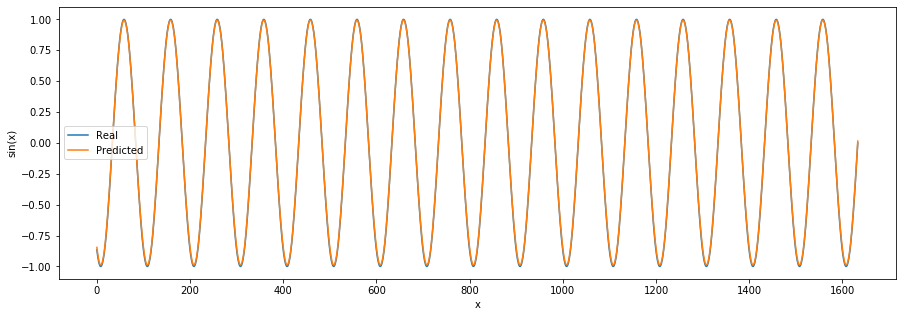

In [10]:
# Predict on test data.
pred_test = model.predict(test_X)

# Apply inverse transformation to get back true values.
test_y_actual = scaler.inverse_transform(test_Y.values.reshape(test_Y.shape[0], 1))

print("MSE on test set: %2f" % mean_squared_error(test_y_actual, pred_test))

plt.figure(figsize = (15, 5))
plt.plot(test_y_actual, label="Real")
plt.plot(pred_test, label="Predicted")
plt.xlabel("x")
plt.ylabel("sin(x)")

plt.legend()
plt.show()

## LSTM 

In [11]:
# Define the model.
model2 = Sequential()
model2.add(LSTM(input_shape = (window_size, 1), units = window_size, return_sequences = True))
model2.add(Dropout(0.5))
model2.add(LSTM(256))
model2.add(Dropout(0.5))
model2.add(Dense(1))
model2.add(Activation("linear"))

model2.compile(loss = "mse", optimizer = "adam")

model2.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 325,025
Train

In [12]:
# Fit the model.
model2.fit(train_X, train_Y, batch_size = 512, epochs = 3, validation_split = 0.1)

Train on 2984 samples, validate on 332 samples
Epoch 1/3
2984/2984 [==============================] - 9s 3ms/step - loss: 0.2858 - val_loss: 0.1034
Epoch 2/3
2984/2984 [==============================] - 7s 3ms/step - loss: 0.0648 - val_loss: 0.0223
Epoch 3/3
2984/2984 [==============================] - 8s 3ms/step - loss: 0.0207 - val_loss: 0.0075


MSE on test set: 0.007748


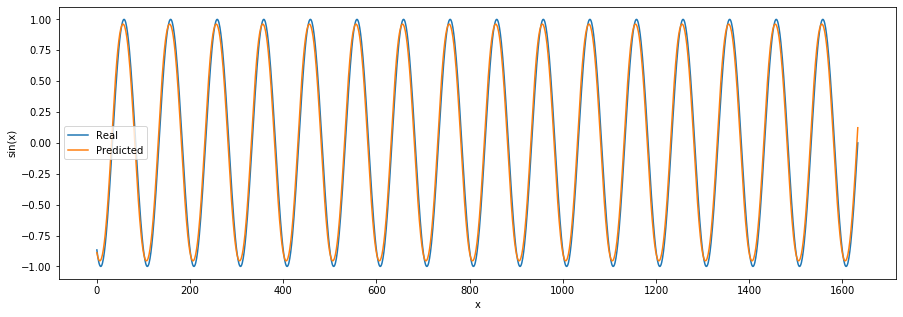

In [13]:
# Predict on test data.
pred_test = model2.predict(test_X)

# Apply inverse transformation to get back true values.
test_y_actual = scaler.inverse_transform(test_Y.values.reshape(test_Y.shape[0], 1))

print("MSE on test set: %2f" % mean_squared_error(test_y_actual, pred_test))

plt.figure(figsize = (15, 5))
plt.plot(test_y_actual, label="Real")
plt.plot(pred_test, label="Predicted")
plt.xlabel("x")
plt.ylabel("sin(x)")

plt.legend()
plt.show()

## GRU

In [14]:
# Define the model.
model3 = Sequential()
model3.add(GRU(input_shape = (window_size, 1), units = window_size, return_sequences = True))
model3.add(Dropout(0.5))
model3.add(LSTM(256))
model3.add(Dropout(0.5))
model3.add(Dense(1))
model3.add(Activation("linear"))

model3.compile(loss = "mse", optimizer = "adam")

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 50, 50)            7800      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 322,425
Trainable params: 322,425
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Fit the model.
model3.fit(train_X, train_Y, batch_size = 512, epochs = 3, validation_split = 0.1)

Train on 2984 samples, validate on 332 samples
Epoch 1/3
2984/2984 [==============================] - 10s 3ms/step - loss: 0.2185 - val_loss: 0.0556
Epoch 2/3
2984/2984 [==============================] - 8s 3ms/step - loss: 0.0469 - val_loss: 0.0243
Epoch 3/3
2984/2984 [==============================] - 8s 3ms/step - loss: 0.0211 - val_loss: 0.0021


MSE on test set: 0.002176


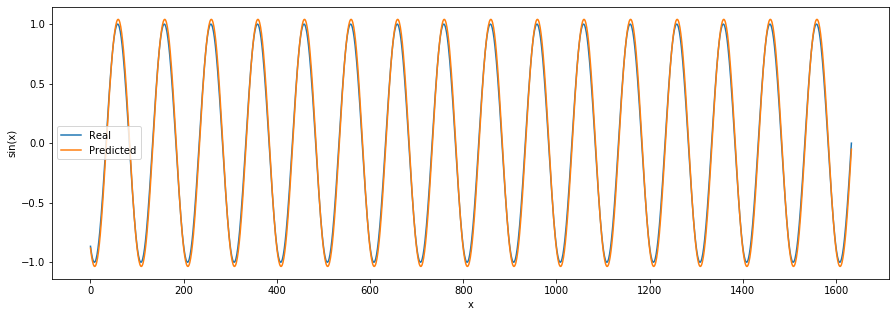

In [16]:
# Predict on test data.
pred_test_3 = model3.predict(test_X)

# Apply inverse transformation to get back true values.
test_y_actual = scaler.inverse_transform(test_Y.values.reshape(test_Y.shape[0], 1))

print("MSE on test set: %2f" % mean_squared_error(test_y_actual, pred_test_3))

plt.figure(figsize = (15, 5))
plt.plot(test_y_actual, label="Real")
plt.plot(pred_test_3, label="Predicted")
plt.xlabel("x")
plt.ylabel("sin(x)")

plt.legend()
plt.show()

# Part 2 Dataset: number of passangers on airplane

* LSTM 
* RNN
* conv-1D
* GRU
* XGBoost

* Download dataset her: https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv


## LSTM 

In [3]:
# Function to convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# fix random seed for reproducibility
numpy.random.seed(7)

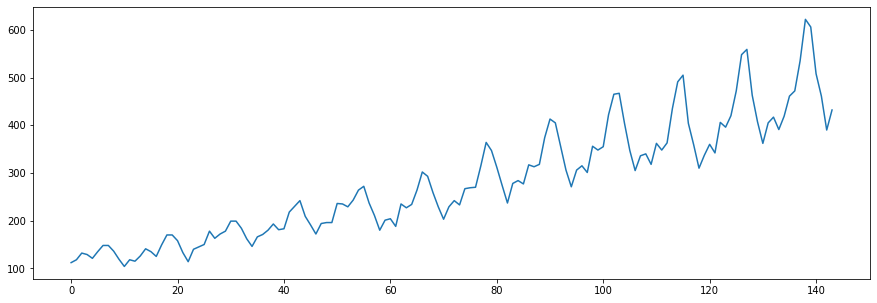

In [4]:
# load the dataset
dataframe = read_csv('airline_passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

plt.figure(figsize = (15, 5))
plt.plot(dataset)
plt.show()

In [10]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [11]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [12]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape,trainY.shape, testX.shape, testY.shape)

(92, 3) (92,) (44, 3) (44,)


In [13]:
# reshape input to be [samples,time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, testX.shape)

(92, 1, 3) (44, 1, 3)


In [14]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
 - 1s - loss: 0.0542
Epoch 2/100
 - 0s - loss: 0.0259
Epoch 3/100
 - 0s - loss: 0.0167
Epoch 4/100
 - 0s - loss: 0.0145
Epoch 5/100
 - 0s - loss: 0.0129
Epoch 6/100
 - 0s - loss: 0.0116
Epoch 7/100
 - 0s - loss: 0.0105
Epoch 8/100
 - 0s - loss: 0.0094
Epoch 9/100
 - 0s - loss: 0.0081
Epoch 10/100
 - 0s - loss: 0.0074
Epoch 11/100
 - 0s - loss: 0.0066
Epoch 12/100
 - 0s - loss: 0.0060
Epoch 13/100
 - 0s - loss: 0.0056
Epoch 14/100
 - 0s - loss: 0.0052
Epoch 15/100
 - 0s - loss: 0.0050
Epoch 16/100
 - 0s - loss: 0.0049
Epoch 17/100
 - 0s - loss: 0.0046
Epoch 18/100
 - 0s - loss: 0.0045
Epoch 19/100
 - 0s - loss: 0.0045
Epoch 20/100
 - 0s - loss: 0.0043
Epoch 21/100
 - 0s - loss: 0.0043
Epoch 22/100
 - 0s - loss: 0.0042
Epoch 23/100
 - 0s - loss: 0.0042
Epoch 24/100
 - 0s - loss: 0.0042
Epoch 25/100
 - 0s - loss: 0.0040
Epoch 26/100
 - 0s - loss: 0.0041
Epoch

In [15]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.05 RMSE
Test Score: 0.11 RMSE


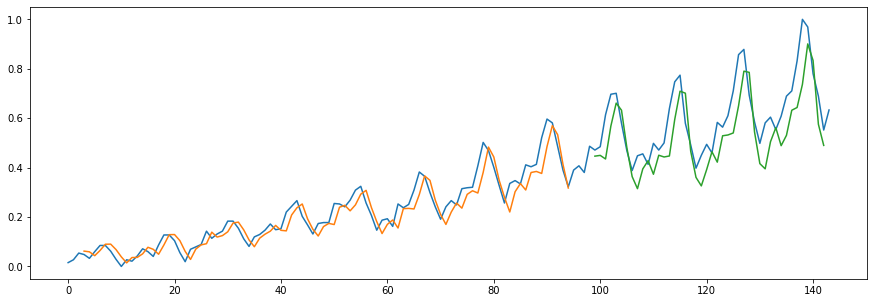

In [16]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Simple RNN

In [17]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape,trainY.shape, testX.shape, testY.shape)

(92, 3) (92,) (44, 3) (44,)


In [18]:
# reshape input to be [samples,time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, testX.shape)

(92, 1, 3) (44, 1, 3)


In [19]:
look_back=3

# Define the model.
model_rnn = Sequential()
model_rnn.add(SimpleRNN(4, input_shape=(1, look_back)))
model_rnn.add(Dense(1))

model_rnn.compile(loss = "mean_squared_error", optimizer = "adam")

model_rnn.summary()

# Fit the first model.
model_rnn.fit(trainX, trainY, epochs = 10, batch_size = 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
92/92 [==============================] - 0s 5ms/step - loss: 0.1296
Epoch 2/10
92/92 [==============================] - 0s 1ms/step - loss: 0.0416
Epoch 3/10
92/92 [==============================] - 0s 1ms/step - loss: 0.0310
Epoch 4/10
92/92 [==============================] - 0s 1ms/step - loss: 0.0253
Epoch 5/10
92/92 [==============================] - 0s 1ms/step - loss: 0.0210
Epoch 6/10
92/92 [==============================] - 0s 1ms/step - loss: 0.0175
Epoch 7/10
92/92 [==============================] - 0s 1ms/step - lo

In [20]:
# make predictions
trainPredict = model_rnn.predict(trainX)
testPredict = model_rnn.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.10 RMSE
Test Score: 0.23 RMSE


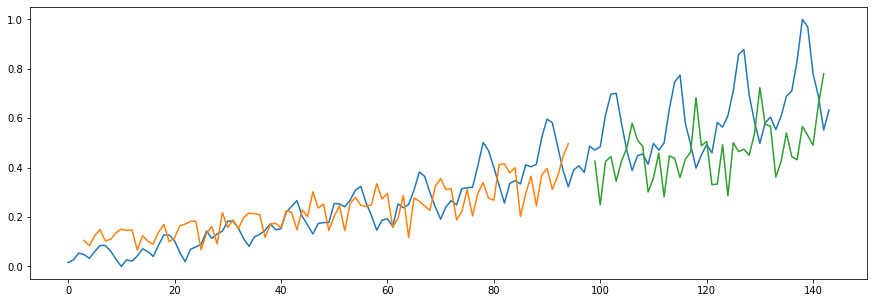

In [21]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Convolution 1 dimension

In [22]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape,trainY.shape, testX.shape, testY.shape)

(92, 3) (92,) (44, 3) (44,)


In [23]:
# reshape input to be [samples,time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print(trainX.shape, testX.shape)

(92, 3, 1) (44, 3, 1)


In [24]:
# define model
look_back = 3

model2 = Sequential()
model2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(look_back, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Flatten())
model2.add(Dense(50, activation='relu'))
model2.add(Dense(1))

model2.compile(optimizer='adam', loss='mse')

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2, 64)             192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3250      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 3,493
Trainable params: 3,493
Non-trainable params: 0
_________________________________________________________________


In [25]:
model2.fit(trainX, trainY, epochs=1000, batch_size=1, verbose=2)

Epoch 1/1000
 - 1s - loss: 0.0119
Epoch 2/1000
 - 0s - loss: 0.0039
Epoch 3/1000
 - 0s - loss: 0.0042
Epoch 4/1000
 - 0s - loss: 0.0041
Epoch 5/1000
 - 0s - loss: 0.0038
Epoch 6/1000
 - 0s - loss: 0.0034
Epoch 7/1000
 - 0s - loss: 0.0032
Epoch 8/1000
 - 0s - loss: 0.0036
Epoch 9/1000
 - 0s - loss: 0.0032
Epoch 10/1000
 - 0s - loss: 0.0032
Epoch 11/1000
 - 0s - loss: 0.0032
Epoch 12/1000
 - 0s - loss: 0.0033
Epoch 13/1000
 - 0s - loss: 0.0032
Epoch 14/1000
 - 0s - loss: 0.0028
Epoch 15/1000
 - 0s - loss: 0.0032
Epoch 16/1000
 - 0s - loss: 0.0033
Epoch 17/1000
 - 0s - loss: 0.0031
Epoch 18/1000
 - 0s - loss: 0.0029
Epoch 19/1000
 - 0s - loss: 0.0031
Epoch 20/1000
 - 0s - loss: 0.0033
Epoch 21/1000
 - 0s - loss: 0.0027
Epoch 22/1000
 - 0s - loss: 0.0028
Epoch 23/1000
 - 0s - loss: 0.0029
Epoch 24/1000
 - 0s - loss: 0.0029
Epoch 25/1000
 - 0s - loss: 0.0029
Epoch 26/1000
 - 0s - loss: 0.0029
Epoch 27/1000
 - 0s - loss: 0.0026
Epoch 28/1000
 - 0s - loss: 0.0026
Epoch 29/1000
 - 0s - loss: 0

Epoch 232/1000
 - 0s - loss: 0.0019
Epoch 233/1000
 - 0s - loss: 0.0020
Epoch 234/1000
 - 0s - loss: 0.0017
Epoch 235/1000
 - 0s - loss: 0.0019
Epoch 236/1000
 - 0s - loss: 0.0019
Epoch 237/1000
 - 0s - loss: 0.0018
Epoch 238/1000
 - 0s - loss: 0.0018
Epoch 239/1000
 - 0s - loss: 0.0018
Epoch 240/1000
 - 0s - loss: 0.0018
Epoch 241/1000
 - 0s - loss: 0.0019
Epoch 242/1000
 - 0s - loss: 0.0019
Epoch 243/1000
 - 0s - loss: 0.0022
Epoch 244/1000
 - 0s - loss: 0.0021
Epoch 245/1000
 - 0s - loss: 0.0020
Epoch 246/1000
 - 0s - loss: 0.0021
Epoch 247/1000
 - 0s - loss: 0.0018
Epoch 248/1000
 - 0s - loss: 0.0018
Epoch 249/1000
 - 0s - loss: 0.0018
Epoch 250/1000
 - 0s - loss: 0.0019
Epoch 251/1000
 - 0s - loss: 0.0020
Epoch 252/1000
 - 0s - loss: 0.0021
Epoch 253/1000
 - 0s - loss: 0.0018
Epoch 254/1000
 - 0s - loss: 0.0018
Epoch 255/1000
 - 0s - loss: 0.0019
Epoch 256/1000
 - 0s - loss: 0.0022
Epoch 257/1000
 - 0s - loss: 0.0018
Epoch 258/1000
 - 0s - loss: 0.0023
Epoch 259/1000
 - 0s - loss:

Epoch 460/1000
 - 0s - loss: 0.0018
Epoch 461/1000
 - 0s - loss: 0.0016
Epoch 462/1000
 - 0s - loss: 0.0017
Epoch 463/1000
 - 0s - loss: 0.0015
Epoch 464/1000
 - 0s - loss: 0.0015
Epoch 465/1000
 - 0s - loss: 0.0016
Epoch 466/1000
 - 0s - loss: 0.0016
Epoch 467/1000
 - 0s - loss: 0.0015
Epoch 468/1000
 - 0s - loss: 0.0014
Epoch 469/1000
 - 0s - loss: 0.0017
Epoch 470/1000
 - 0s - loss: 0.0016
Epoch 471/1000
 - 0s - loss: 0.0013
Epoch 472/1000
 - 0s - loss: 0.0016
Epoch 473/1000
 - 0s - loss: 0.0014
Epoch 474/1000
 - 0s - loss: 0.0014
Epoch 475/1000
 - 0s - loss: 0.0014
Epoch 476/1000
 - 0s - loss: 0.0013
Epoch 477/1000
 - 0s - loss: 0.0014
Epoch 478/1000
 - 0s - loss: 0.0014
Epoch 479/1000
 - 0s - loss: 0.0014
Epoch 480/1000
 - 0s - loss: 0.0015
Epoch 481/1000
 - 0s - loss: 0.0014
Epoch 482/1000
 - 0s - loss: 0.0014
Epoch 483/1000
 - 0s - loss: 0.0017
Epoch 484/1000
 - 0s - loss: 0.0015
Epoch 485/1000
 - 0s - loss: 0.0020
Epoch 486/1000
 - 0s - loss: 0.0020
Epoch 487/1000
 - 0s - loss:

Epoch 688/1000
 - 0s - loss: 0.0012
Epoch 689/1000
 - 0s - loss: 0.0013
Epoch 690/1000
 - 0s - loss: 0.0016
Epoch 691/1000
 - 0s - loss: 0.0016
Epoch 692/1000
 - 0s - loss: 0.0014
Epoch 693/1000
 - 0s - loss: 0.0014
Epoch 694/1000
 - 0s - loss: 0.0013
Epoch 695/1000
 - 0s - loss: 0.0013
Epoch 696/1000
 - 0s - loss: 0.0013
Epoch 697/1000
 - 0s - loss: 0.0014
Epoch 698/1000
 - 0s - loss: 0.0016
Epoch 699/1000
 - 0s - loss: 0.0013
Epoch 700/1000
 - 0s - loss: 0.0013
Epoch 701/1000
 - 0s - loss: 0.0013
Epoch 702/1000
 - 0s - loss: 0.0014
Epoch 703/1000
 - 0s - loss: 0.0012
Epoch 704/1000
 - 0s - loss: 0.0015
Epoch 705/1000
 - 0s - loss: 0.0016
Epoch 706/1000
 - 0s - loss: 0.0013
Epoch 707/1000
 - 0s - loss: 0.0012
Epoch 708/1000
 - 0s - loss: 0.0014
Epoch 709/1000
 - 0s - loss: 0.0013
Epoch 710/1000
 - 0s - loss: 0.0014
Epoch 711/1000
 - 0s - loss: 0.0013
Epoch 712/1000
 - 0s - loss: 0.0013
Epoch 713/1000
 - 0s - loss: 0.0012
Epoch 714/1000
 - 0s - loss: 0.0014
Epoch 715/1000
 - 0s - loss:

Epoch 916/1000
 - 0s - loss: 0.0014
Epoch 917/1000
 - 0s - loss: 0.0013
Epoch 918/1000
 - 0s - loss: 0.0012
Epoch 919/1000
 - 0s - loss: 0.0011
Epoch 920/1000
 - 0s - loss: 0.0012
Epoch 921/1000
 - 0s - loss: 0.0012
Epoch 922/1000
 - 0s - loss: 0.0014
Epoch 923/1000
 - 0s - loss: 0.0014
Epoch 924/1000
 - 0s - loss: 0.0012
Epoch 925/1000
 - 0s - loss: 0.0015
Epoch 926/1000
 - 0s - loss: 0.0012
Epoch 927/1000
 - 0s - loss: 0.0014
Epoch 928/1000
 - 0s - loss: 0.0012
Epoch 929/1000
 - 0s - loss: 0.0013
Epoch 930/1000
 - 0s - loss: 0.0011
Epoch 931/1000
 - 0s - loss: 0.0014
Epoch 932/1000
 - 0s - loss: 0.0013
Epoch 933/1000
 - 0s - loss: 0.0011
Epoch 934/1000
 - 0s - loss: 0.0012
Epoch 935/1000
 - 0s - loss: 0.0014
Epoch 936/1000
 - 0s - loss: 0.0012
Epoch 937/1000
 - 0s - loss: 0.0015
Epoch 938/1000
 - 0s - loss: 0.0015
Epoch 939/1000
 - 0s - loss: 0.0014
Epoch 940/1000
 - 0s - loss: 0.0013
Epoch 941/1000
 - 0s - loss: 0.0011
Epoch 942/1000
 - 0s - loss: 0.0012
Epoch 943/1000
 - 0s - loss:

In [26]:
# make predictions
trainPredict = model2.predict(trainX)
testPredict = model2.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.03 RMSE
Test Score: 0.15 RMSE


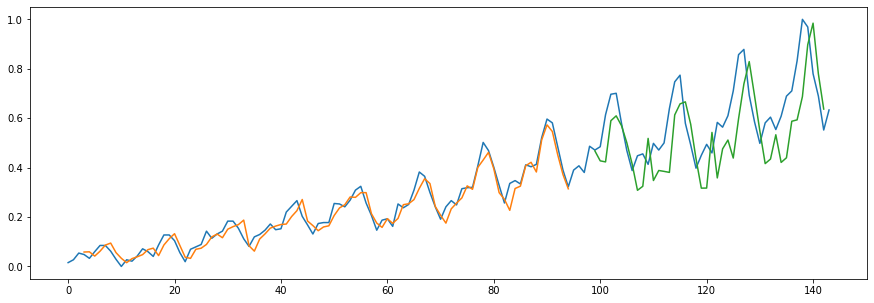

In [27]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## GRU

In [28]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape,trainY.shape, testX.shape, testY.shape)

(92, 3) (92,) (44, 3) (44,)


In [29]:
# reshape input to be [samples,time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, testX.shape)

(92, 1, 3) (44, 1, 3)


In [31]:
# Define the model.
look_back = 3

model4 = Sequential()
model4.add(GRU(input_shape=(1, look_back), units = look_back, return_sequences = True))
model4.add(Dropout(0.5))
model4.add(LSTM(256))
model4.add(Dropout(0.5))
model4.add(Dense(1))
model4.add(Activation("linear"))

model4.compile(loss = "mse", optimizer = "adam")

model4.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 1, 3)              63        
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 3)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               266240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 266,560
Train

In [32]:
model4.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 2s - loss: 0.0237
Epoch 2/100
 - 1s - loss: 0.0131
Epoch 3/100
 - 1s - loss: 0.0122
Epoch 4/100
 - 1s - loss: 0.0094
Epoch 5/100
 - 1s - loss: 0.0129
Epoch 6/100
 - 1s - loss: 0.0112
Epoch 7/100
 - 1s - loss: 0.0098
Epoch 8/100
 - 1s - loss: 0.0068
Epoch 9/100
 - 1s - loss: 0.0070
Epoch 10/100
 - 1s - loss: 0.0097
Epoch 11/100
 - 1s - loss: 0.0075
Epoch 12/100
 - 1s - loss: 0.0068
Epoch 13/100
 - 1s - loss: 0.0081
Epoch 14/100
 - 1s - loss: 0.0060
Epoch 15/100
 - 1s - loss: 0.0080
Epoch 16/100
 - 1s - loss: 0.0080
Epoch 17/100
 - 1s - loss: 0.0074
Epoch 18/100
 - 1s - loss: 0.0070
Epoch 19/100
 - 1s - loss: 0.0077
Epoch 20/100
 - 1s - loss: 0.0062
Epoch 21/100
 - 1s - loss: 0.0066
Epoch 22/100
 - 1s - loss: 0.0059
Epoch 23/100
 - 1s - loss: 0.0069
Epoch 24/100
 - 1s - loss: 0.0087
Epoch 25/100
 - 1s - loss: 0.0053
Epoch 26/100
 - 1s - loss: 0.0076
Epoch 27/100
 - 1s - loss: 0.0073
Epoch 28/100
 - 1s - loss: 0.0081
Epoch 29/100
 - 1s - loss: 0.0092
Epoch 30/100
 - 1s - lo

In [33]:
# make predictions
trainPredict = model4.predict(trainX)
testPredict = model4.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.06 RMSE
Test Score: 0.18 RMSE


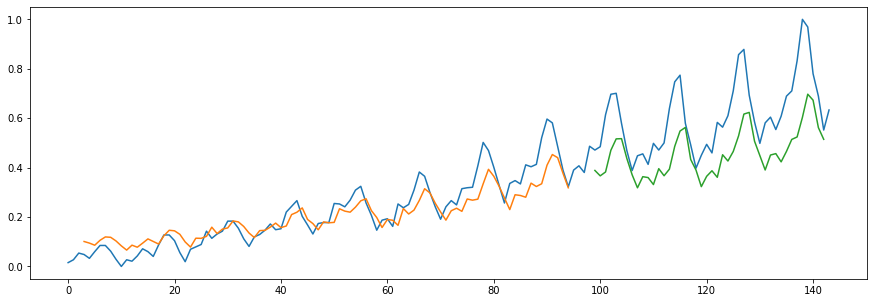

In [34]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## XGboost

In [37]:
df2= pd.read_csv('airline_passengers.csv', index_col=[0], parse_dates=[0])
df2.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [38]:
# Split
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

C:\Users\Utilisateur\Anaconda3\envs\computervision\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


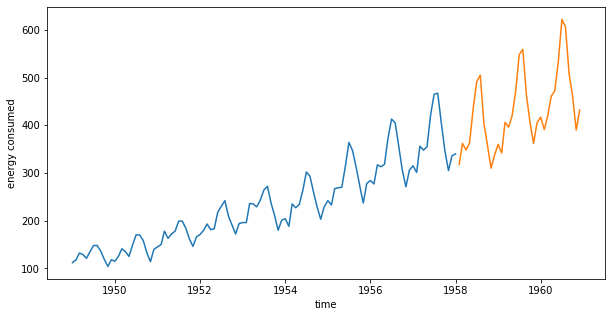

In [39]:
train, test = split_data(df2, '1958')

plt.figure(figsize=(10,5))
plt.xlabel('time')
plt.ylabel('energy consumed')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show()

In [40]:
# Creates time series features from datetime index
def create_features(df):

    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    
    X = df[['hour','month','year']]
    return X

In [41]:
X_train, y_train = create_features(train), train['Thousands of Passengers']
X_test, y_test   = create_features(test), test['Thousands of Passengers']

X_train.shape, y_train.shape

((109, 3), (109,))

In [42]:
#Create and Train XGBoost Model
import xgboost as xgboost
from xgboost import XGBRegressor

reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, 
        verbose=True) 

[0]	validation_0-rmse:223.358	validation_1-rmse:406.246
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:202.391	validation_1-rmse:378.102
[2]	validation_0-rmse:183.509	validation_1-rmse:351.146
[3]	validation_0-rmse:166.56	validation_1-rmse:326.874
[4]	validation_0-rmse:151.266	validation_1-rmse:305.028
[5]	validation_0-rmse:137.488	validation_1-rmse:286.436
[6]	validation_0-rmse:125.177	validation_1-rmse:268.66
[7]	validation_0-rmse:114.067	validation_1-rmse:252.685
[8]	validation_0-rmse:104.024	validation_1-rmse:238.863
[9]	validation_0-rmse:94.8322	validation_1-rmse:226.858
[10]	validation_0-rmse:86.5533	validation_1-rmse:215.36
[11]	validation_0-rmse:79.1007	validation_1-rmse:204.956
[12]	validation_0-rmse:72.4305	validation_1-rmse:194.794
[13]	validation_0-rmse:66.4495	validation_1-rmse:185.623
[14]	validation_0-rmse:61.0219	validation_1-rmse:176.094

[141]	validation_0-rmse:3.40954	validation_1-rmse:67.9016
[142]	validation_0-rmse:3.40442	validation_1-rmse:67.894
[143]	validation_0-rmse:3.37932	validation_1-rmse:67.862
[144]	validation_0-rmse:3.37446	validation_1-rmse:67.8608
[145]	validation_0-rmse:3.35263	validation_1-rmse:67.8507
[146]	validation_0-rmse:3.34184	validation_1-rmse:67.8423
[147]	validation_0-rmse:3.33605	validation_1-rmse:67.8341
[148]	validation_0-rmse:3.32685	validation_1-rmse:67.8157
[149]	validation_0-rmse:3.31515	validation_1-rmse:67.8071
[150]	validation_0-rmse:3.30672	validation_1-rmse:67.7985
[151]	validation_0-rmse:3.29672	validation_1-rmse:67.7908
[152]	validation_0-rmse:3.28679	validation_1-rmse:67.773
[153]	validation_0-rmse:3.2735	validation_1-rmse:67.7608
[154]	validation_0-rmse:3.26386	validation_1-rmse:67.7438
[155]	validation_0-rmse:3.25101	validation_1-rmse:67.758
[156]	validation_0-rmse:3.24413	validation_1-rmse:67.7315
[157]	validation_0-rmse:3.2358	validation_1-rmse:67.7462
[158]	validation_0-r

[283]	validation_0-rmse:2.57748	validation_1-rmse:67.4196
[284]	validation_0-rmse:2.57344	validation_1-rmse:67.4124
[285]	validation_0-rmse:2.56759	validation_1-rmse:67.4126
[286]	validation_0-rmse:2.5668	validation_1-rmse:67.4051
[287]	validation_0-rmse:2.56313	validation_1-rmse:67.3979
[288]	validation_0-rmse:2.56002	validation_1-rmse:67.3914
[289]	validation_0-rmse:2.55172	validation_1-rmse:67.3924
[290]	validation_0-rmse:2.5427	validation_1-rmse:67.3938
[291]	validation_0-rmse:2.53498	validation_1-rmse:67.3952
[292]	validation_0-rmse:2.52836	validation_1-rmse:67.3965
[293]	validation_0-rmse:2.52732	validation_1-rmse:67.3877
[294]	validation_0-rmse:2.52672	validation_1-rmse:67.3794
[295]	validation_0-rmse:2.52385	validation_1-rmse:67.3734
[296]	validation_0-rmse:2.52296	validation_1-rmse:67.3654
[297]	validation_0-rmse:2.52241	validation_1-rmse:67.3578
[298]	validation_0-rmse:2.51994	validation_1-rmse:67.3523
[299]	validation_0-rmse:2.51785	validation_1-rmse:67.3473
[300]	validation

[425]	validation_0-rmse:2.16756	validation_1-rmse:67.2385
[426]	validation_0-rmse:2.16466	validation_1-rmse:67.2398
[427]	validation_0-rmse:2.16005	validation_1-rmse:67.2403
[428]	validation_0-rmse:2.15791	validation_1-rmse:67.2365
[429]	validation_0-rmse:2.15703	validation_1-rmse:67.2352
[430]	validation_0-rmse:2.15638	validation_1-rmse:67.2318
[431]	validation_0-rmse:2.15324	validation_1-rmse:67.2335
[432]	validation_0-rmse:2.1503	validation_1-rmse:67.2351
[433]	validation_0-rmse:2.14806	validation_1-rmse:67.2366
[434]	validation_0-rmse:2.14367	validation_1-rmse:67.2301
[435]	validation_0-rmse:2.1398	validation_1-rmse:67.2323
[436]	validation_0-rmse:2.13737	validation_1-rmse:67.2323
[437]	validation_0-rmse:2.13528	validation_1-rmse:67.2323
[438]	validation_0-rmse:2.13346	validation_1-rmse:67.2388
[439]	validation_0-rmse:2.13172	validation_1-rmse:67.2387
[440]	validation_0-rmse:2.13029	validation_1-rmse:67.2447
[441]	validation_0-rmse:2.1284	validation_1-rmse:67.2467
[442]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1)

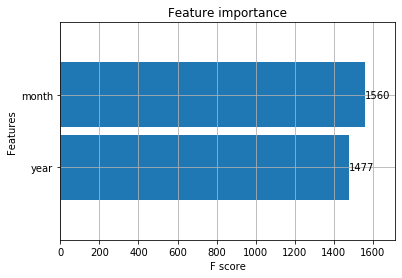

In [43]:
# Most relevants features
xgb.plot_importance(reg, height=0.9)

In [44]:
def plot_performance(base_data, date_from, date_to, title=None):
    
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.xlabel('time')
    plt.ylabel('number of passangers')
    plt.plot(df2.index,df2, label='real')
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

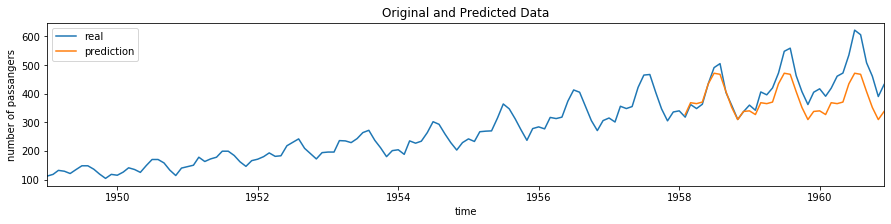

In [45]:
X_test_pred = reg.predict(X_test)
plot_performance(df2, df2.index[0].date(), df2.index[-1].date(),'Original and Predicted Data')
plt.legend()

plt.show()

In [46]:
# MSE
mean_squared_error(y_true=y_test, y_pred=X_test_pred)

4519.679420139773

# Ref:

* LSTM time series: https://github.com/Tony607/Keras_TimeseriesGenerator/blob/master/TimeseriesGenerator.ipynb / https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

* Convolution 1D: https://machinelearningmastery.com/how-to-develop-convolutional-neural-network-models-for-time-series-forecasting/

* XGBoost time series: https://www.kaggle.com/furiousx7/xgboost-time-series
